# Adhesin Classification

In [258]:
%%capture
!pip install Biopython
!rm -r iFeature
!rm -r spaan
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/spaan

import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

np.random.seed(42)

## Compute features from sequences using iFeature

In [3]:
'''
# put the right path
!python iFeature/iFeature.py --file ./adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./non_adhesins.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./non_adhesins.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./non_adhesins.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./non_adhesins.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")
'''

Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
pos: DONE!
Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
neg: DONE!


In [259]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_cleaned_pos"
    else:
        names = "_cleaned_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [260]:
# put the right path
pos_datasets = from_files_to_vectors("./spaan/new_data/", positive=True)
neg_datasets = from_files_to_vectors("./spaan/new_data/", positive=False)

# I'll keep all the data. Maybe we will reduce the number of sequences

In [262]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [264]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])

Adhesins: 12066
NON Adhesins: 11259
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (23325, 693)


In [265]:
# permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [ ]:
# we should remove outliers

In [266]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining adhesins and not-adhesins:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation adhesins and not-adhesins:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (11662, 693) (11662,)
Validation data shape: (5831, 693) (5831,)
Test data shape: (5832, 693) (5832,)

Training adhesins and not-adhesins: 6064 5598
Validation adhesins and not-adhesins: 3022 2809
Test adhesins and not-adhesins: 2980 2852


## PCA

In [267]:
# standardize data

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
for j in range(X_train.shape[1]):
    column = X_train[:,j]
    stdX[:,j] = (column - np.mean(column)) / np.std(column)

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

Before standardization:
mean of the first column: 0.08810092882125989
mean of the second column: 0.0097357459068374
mean of the 451-th column: 0.10095968182272048
After standardization:
mean of the first column: -3.777538125289505e-17
mean of the second column: -2.5589774397122455e-17
mean of the 451-th column: -3.777538125289505e-17


In [268]:
covariance_matrix = np.cov(stdX.T)

In [269]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [270]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[7.516294200154618, 5.313680361017345, 3.6723750923904155, 3.231212014926002, 2.8035406716915157, 2.7438304982374917, 2.2625732015930535, 1.5167396772253348, 1.470825428146379, 1.0442435320889554, 0.9986144583262474, 0.9628886005647933, 0.925853690273241, 0.8639382474289876, 0.8252398177491521, 0.7803239572606263, 0.7176516727561195, 0.7097049301570925, 0.6185529211179563, 0.6042499205607114, 0.5972904879693072, 0.5744643723277311, 0.5631714330272551, 0.5397889881249017, 0.5063491220185472, 0.4909050094155338, 0.47705643553734944, 0.4612000696754059, 0.44779119910826604, 0.4452795231300166, 0.4347131196535382, 0.4152760637323528, 0.4058924147866563, 0.4034850689723994, 0.39169042109197744, 0.3820807117158985, 0.3690628667687745, 0.3405157464034156, 0.33778308271393087, 0.31847530077048797, 0.3120061775915779, 0.2935207699970645, 0.2881212454777292, 0.28076530352101414, 0.2741321133874438, 0.2688015181722479, 0.2647947002915196, 0.2626759822625996, 0.2561215639132781, 0.2510776762790955

In [271]:
cumulative_variance_explained = np.cumsum(variance_explained)

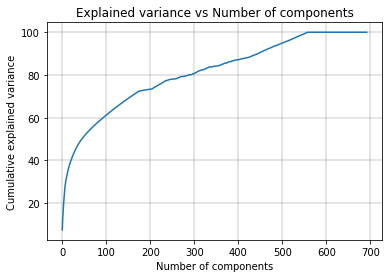

In [272]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [273]:
K = 550
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 550
Discarded components: 143


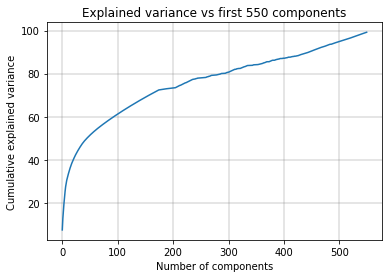

In [274]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [276]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

(693, 550)


In [277]:
# standardize validation and test data and then project

stdX_val = np.zeros(X_val.shape)
for j in range(X_val.shape[1]):
    column = X_val[:,j]
    stdX_val[:,j] = (column - np.mean(column)) / np.std(column)

stdX_test = np.zeros(X_test.shape)
for j in range(X_test.shape[1]):
    column = X_test[:,j]
    stdX_test[:,j] = (column - np.mean(column)) / np.std(column)

# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

## Neural Network

In [284]:
class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(50, activation='sigmoid')(input)
        norm = tensorflow.keras.layers.BatchNormalization()(dense)
        drop = tensorflow.keras.layers.Dropout(.5)(norm)
        dense = tensorflow.keras.layers.Dense(50, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [285]:
nn = neural_network()

In [286]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=400,
    verbose=0,
    validation_data=(X_val, y_val),
    #shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=20
        )]
)

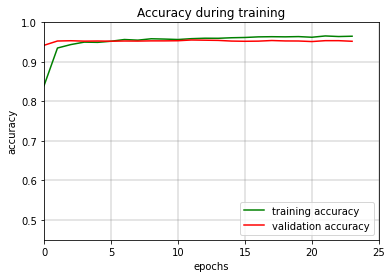

In [287]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

In [288]:
nn.model.evaluate(x=X_test, y=y_test)

183/183 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9528


[0.13694004714488983, 0.952846348285675]

In [289]:
nn.model.save('new_spaan_model.h5')